# Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import Rescaling
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from PIL import Image
from pathlib import Path
import os
from tqdm import tqdm
import cv2
Mean_IoU = tf.keras.metrics.MeanIoU(num_classes=2)

# Display an image


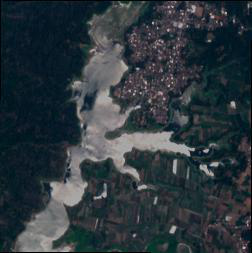

/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Images
Size of the Image (252, 253)



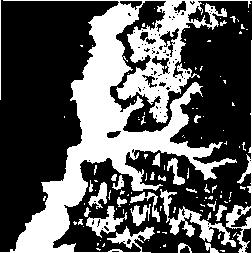

/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Masks
Size of the Image (252, 253)


In [2]:
def display_image(path):# Display a image from test set
    with Image.open(path) as im:
        fig = px.imshow(im)
        fig.update_layout(title=Path(path).stem, width=500)
        fig.show()
        print(os.path.dirname(path))
        images_size = im.size
        print( 'Size of the Image', im.size )
        
display_image(path="/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Images/water_body_10.jpg")
display_image(path="/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Masks/water_body_10.jpg")

# Import Images | Resize | Crop | Reshape | Masking of Masks

In [3]:
images_dir = "/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Images/"
masks_dir = "/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Masks/"

images_filenames = [images_dir + filename for filename in os.listdir(images_dir) ]
masks_filenames = [masks_dir + filename for filename in os.listdir(masks_dir) ]

In [4]:
input_size = 256
output_size = 256
min_pixel, max_pixel = 0,255

In [5]:
def decode_image(image_file_names,size=256, mode="RGB"):
    images = []
    for i in tqdm(range(len(image_file_names))):
        img=Image.open(image_file_names[i])
        if mode == "BW":
            img = img.convert("L")
            width, height = img.size
            left = width/15
            top = height / 15
            right = 14*width/15
            bottom = 14 * height / 15
            img = img.crop((left, top, right, bottom))
            img = np.array(img)
            img = cv2.threshold(img, int((max_pixel+min_pixel)/2) , 1, cv2.THRESH_BINARY)[1]
            img = cv2.resize(img,dsize=(size,size))
            img = np.reshape(img,[img.shape[0],img.shape[1],1])
            
        else:
            width, height = img.size
            left = width/15
            top = height / 15
            right = 14*width/15
            bottom = 14 * height / 15
            img = img.crop((left, top, right, bottom))
            img = np.array(img)
            img = cv2.resize(img,dsize=(size,size))
            img = np.reshape(img,[img.shape[0],img.shape[1],3])
            
        img=np.array(img)
        images.append(img)
        #print(img.shape)
    print('Done --')
    return  np.stack(images, axis=0)

In [6]:
images = decode_image(images_filenames, size=input_size )
masks = decode_image(masks_filenames, size=output_size, mode = "BW" )

100%|██████████| 2494/2494 [00:30<00:00, 81.55it/s] 


Done --


100%|██████████| 2494/2494 [00:22<00:00, 110.36it/s]

Done --


In [7]:
masks.shape, images.shape

((2494, 256, 256, 1), (2494, 256, 256, 3))

<class 'numpy.ndarray'> (256, 256, 3)


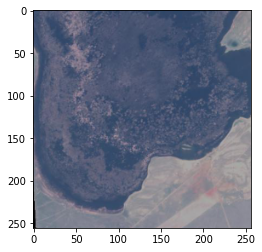

<class 'numpy.ndarray'> (256, 256, 1)


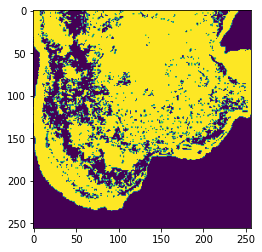

-------------------------------------------------------------
<class 'numpy.ndarray'> (256, 256, 3)


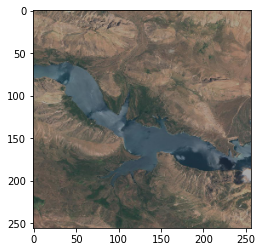

<class 'numpy.ndarray'> (256, 256, 1)


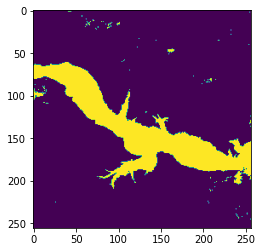

-------------------------------------------------------------
<class 'numpy.ndarray'> (256, 256, 3)


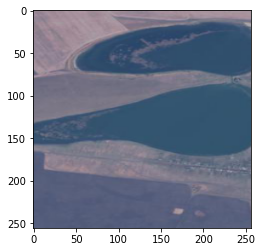

<class 'numpy.ndarray'> (256, 256, 1)


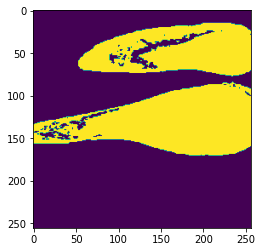

-------------------------------------------------------------


In [8]:
for i in range(3):
    print(type(images[i]),images[i].shape)
    plt.imshow(images[i])
    plt.show()
    print(type(masks[i]),masks[i].shape)
    plt.imshow(masks[i])
    plt.show()
    print("-------------------------------------------------------------")

In [9]:
def load_img_with_mask(image_path, images_dir: str = 'Images', masks_dir: str = 'Masks',images_extension: str = 'jpg', masks_extension: str = 'jpg') -> dict:
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # image = tf.reshape(image,tf.constant((-1,256,256,3)))
    image = tf.image.central_crop(image, central_fraction=0.95)
    image = tf.image.resize(image, size=[256,256])
    
    
    mask_filename = tf.strings.regex_replace(image_path, images_dir, masks_dir)
    mask_filename = tf.strings.regex_replace(mask_filename, images_extension, masks_extension)
    mask = tf.io.read_file(mask_filename)
    mask = tf.image.decode_image(mask, channels=1, expand_animations = False)
    # mask = tf.reshape(mask,tf.constant((-1,256,256,1)))    
    mask = tf.image.central_crop(mask, central_fraction=0.95)
    mask = tf.image.resize(mask, size=[256,256])
    mask = tf.where(mask>int((max_pixel+min_pixel)/2),1,0)
    return (image, mask)

BATCH_SIZE = 8
SHUFFLE_BUFFER_SIZE = 10
AUTOTUNE = tf.data.AUTOTUNE

dataset = tf.data.Dataset.list_files("/kaggle/input/water-body-segmentation-in-satellite-images/Water Bodies Dataset Preprocessed/Water Bodies Dataset Preprocessed/Images" + '/*.jpg', seed=10)
test_set_size = 94
validation_set_size = 400 

test_dataset = dataset.take(test_set_size)
dataset = dataset.skip(test_set_size)
test_dataset = test_dataset.map(load_img_with_mask)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

validation_dataset = dataset.take(validation_set_size)
train_dataset = dataset.skip(validation_set_size)
validation_dataset = validation_dataset.map(load_img_with_mask)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

train_dataset = train_dataset.map(load_img_with_mask)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Creating U-Net Architure using Tensorflow | Training Model

In [10]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, Concatenate


input_layer = Input(shape=(None, None, 3))

# Encoder
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

# Middle
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

# Decoder
up6 = Concatenate()([UpSampling2D(size=(2, 2))(conv5), conv4])
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

up7 = Concatenate()([UpSampling2D(size=(2, 2))(conv6), conv3])
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up8 = Concatenate()([UpSampling2D(size=(2, 2))(conv7), conv2])
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up9 = Concatenate()([UpSampling2D(size=(2, 2))(conv8), conv1])
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

# Output
output_layer = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = keras.models.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

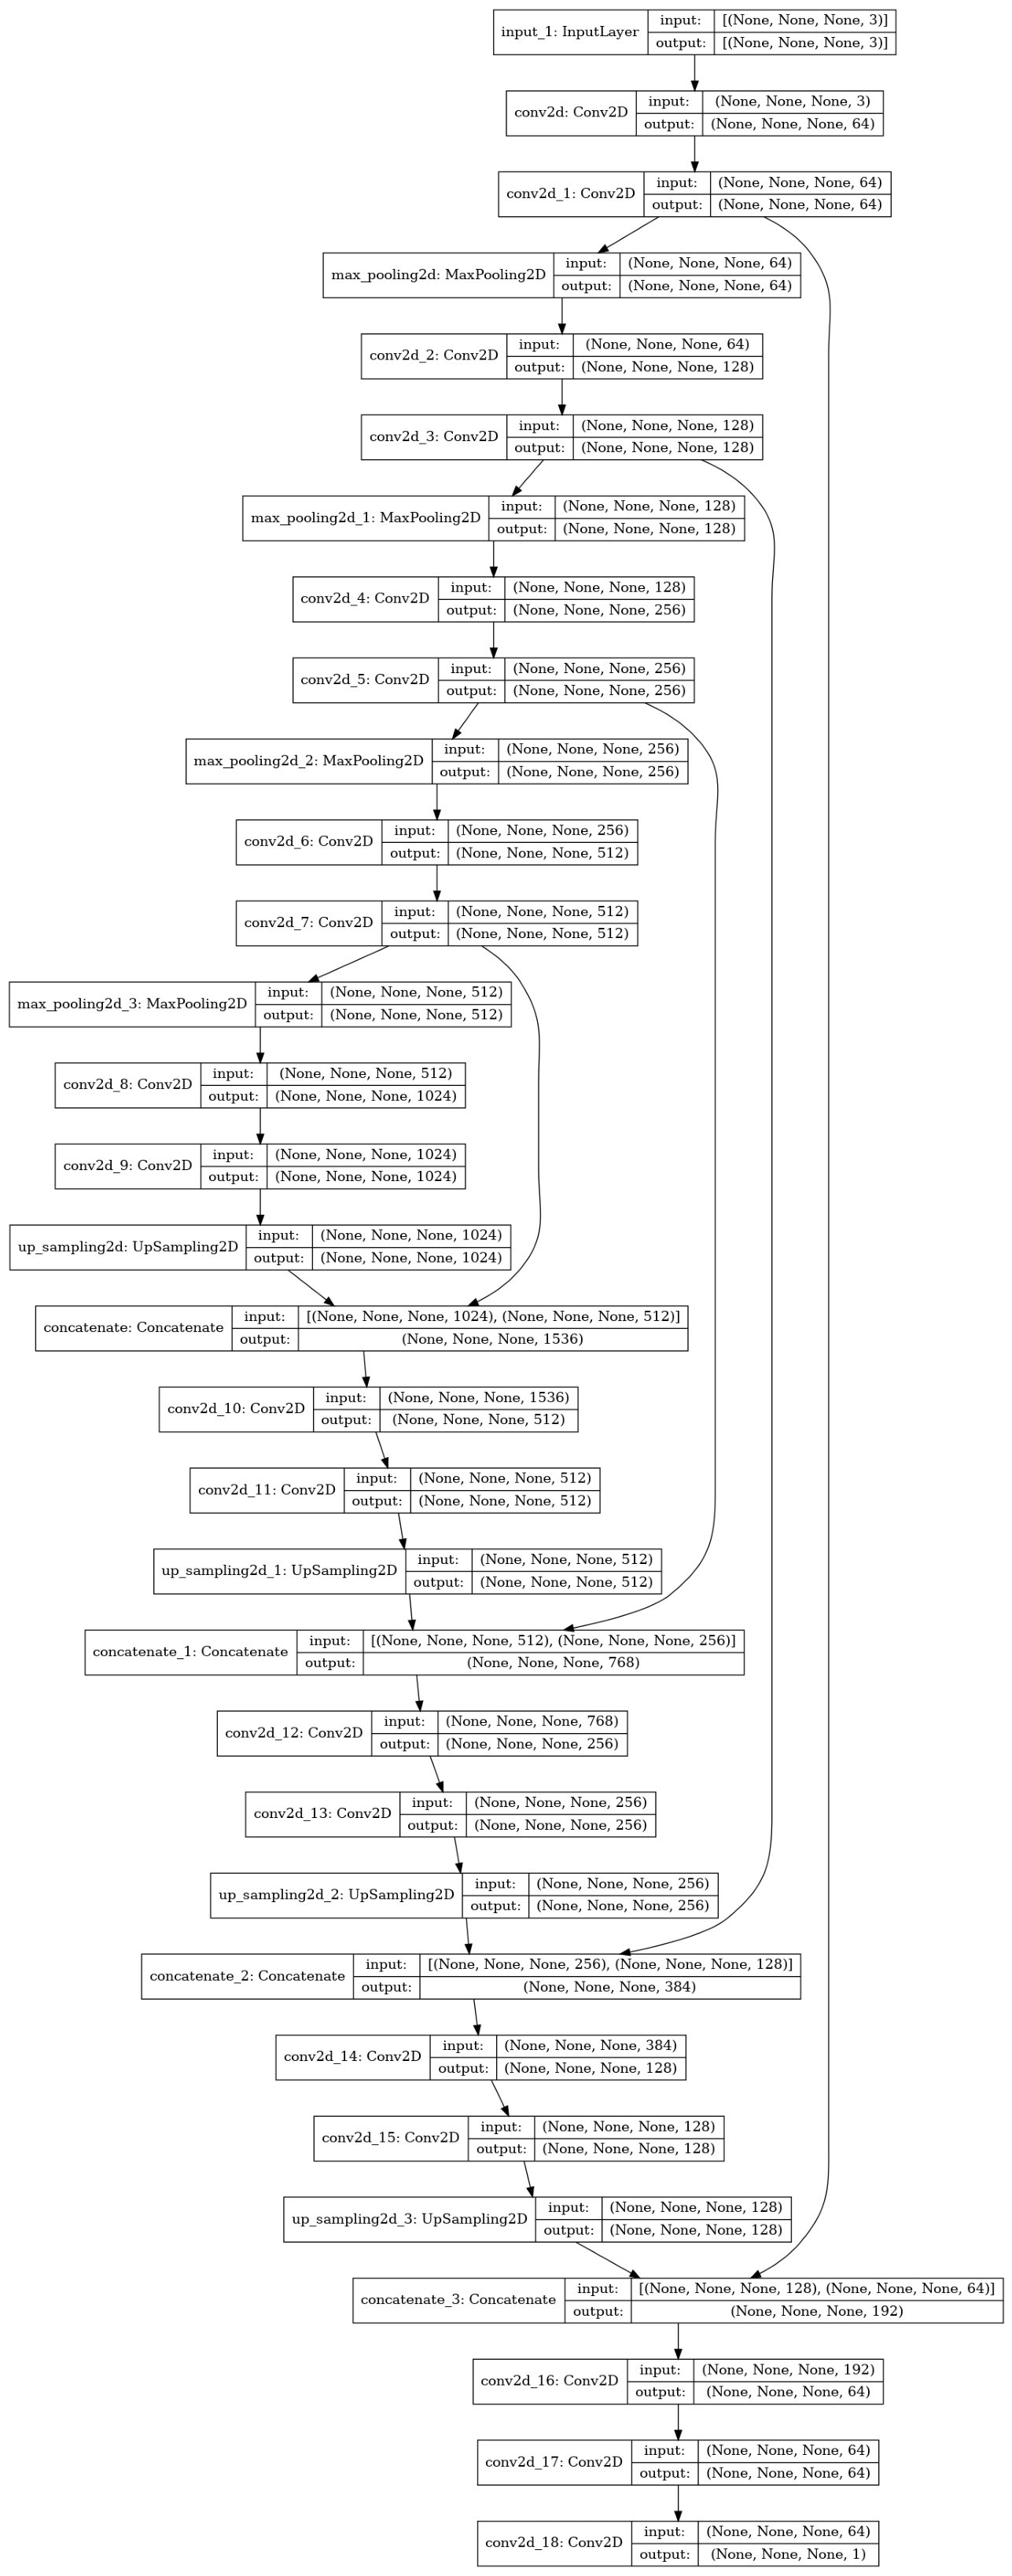

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='UNet_model.png', show_shapes=True)
image = Image.open("/kaggle/working/UNet_model.png")

# Create a subplot with a specific size
fig, ax = plt.subplots(figsize=(64, 60))  # Specify width and height in inches
# Plot your data
plt.imshow(image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()

In [12]:
# model = Sequential()
# model.add( keras.layers.Input(shape=(None,None,3)))
# # model.add( tf.keras.layers.Resizing(input_size,input_size))
# # model.add( tf.keras.layers.Rescaling( 1./255 ))
          
# model.add( Conv2D( filters=64, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( Conv2D( filters=64, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( BatchNormalization() )
# model.add( MaxPooling2D(pool_size=(2,2),strides=2))
            
# model.add( Conv2D( filters=128, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( Conv2D( filters=128, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( BatchNormalization() )
# model.add( MaxPooling2D(pool_size=(2,2),strides=(2,2) ))

# model.add( Conv2D( filters=256, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( Conv2D( filters=256, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( BatchNormalization() )
# model.add( MaxPooling2D(pool_size=(2,2),strides=2) )
          
# model.add( Conv2D( filters=512, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( Conv2D( filters=512, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( BatchNormalization() )
# model.add( MaxPooling2D(pool_size=(2,2),strides=2) )
          
# model.add( Conv2D( filters=1024, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( Conv2D( filters=1024, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( BatchNormalization() )
# model.add( UpSampling2D(size=(2,2)) )

# model.add( Conv2D( filters=512, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( Conv2D( filters=512, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( BatchNormalization() )
# model.add( UpSampling2D(size=(2,2)) )

# model.add( Conv2D( filters=256, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( Conv2D( filters=256, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( BatchNormalization() )
# model.add( UpSampling2D(size=(2,2)) )

# model.add( Conv2D( filters=128, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( Conv2D( filters=128, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( BatchNormalization() )
# model.add( UpSampling2D(size=(2,2)) )

# model.add( Conv2D( filters=64, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( Conv2D( filters=64, kernel_size=(3,3), padding='same', activation='relu') )
# model.add( BatchNormalization() )

# model.add( Conv2D( filters=1, kernel_size=(1,1), padding='same', activation='sigmoid') )

# model.compile( optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy())
# model.summary()

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1)
MCP = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/model/", save_best_only=True)
history = model.fit( train_dataset, validation_data=validation_dataset , epochs=250, callbacks=[early_stopping,MCP,lr_reduce], batch_size=BATCH_SIZE) 

Epoch 1/250
250/250 [==============================] - 74s 246ms/step - loss: 7.2851 - val_loss: 0.5068
Epoch 2/250
250/250 [==============================] - 61s 245ms/step - loss: 0.5038 - val_loss: 0.5216
Epoch 3/250
250/250 [==============================] - 61s 245ms/step - loss: 0.4754 - val_loss: 0.4855
Epoch 4/250
250/250 [==============================] - 61s 244ms/step - loss: 0.4950 - val_loss: 0.4791
Epoch 5/250
250/250 [==============================] - 61s 245ms/step - loss: 0.4687 - val_loss: 0.4646
Epoch 6/250
250/250 [==============================] - 61s 244ms/step - loss: 0.4588 - val_loss: 0.4855
Epoch 7/250
250/250 [==============================] - 61s 244ms/step - loss: 0.4377 - val_loss: 0.4221
Epoch 8/250
250/250 [==============================] - 61s 245ms/step - loss: 0.4263 - val_loss: 0.3845
Epoch 9/250
250/250 [==============================] - 61s 244ms/step - loss: 0.4123 - val_loss: 0.3566
Epoch 10/250
250/250 [==============================] - 61s 245m

In [14]:
model.save('image_segmentation_model_UNet.h5')

# Loss vs epochs graph


In [15]:
def Plot_Loss_Accuracy( history, epochs ):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = np.linspace(1,epochs,epochs)
    epochs
    fig = go.Figure(data=go.Scatter( x=epochs, y=loss, name='loss' ))
    fig.add_trace( go.Scatter( x=epochs, y=val_loss, name='val_loss' ) )
    fig.update_layout( title="Loss", xaxis_title='epochs' )
    fig.show()
    
Plot_Loss_Accuracy( history, epochs=50 )

# Predicted Segmented Images

In [16]:
model = tf.keras.models.load_model('/kaggle/working/image_segmentation_model_UNet.h5')

In [17]:
for data in test_dataset.take(test_set_size):
    images, masks = data[0].numpy(), data[1].numpy()
    preds =  tf.where(model.predict(images) > 0.5, 1, 0)

Original Image (256, 256, 3)



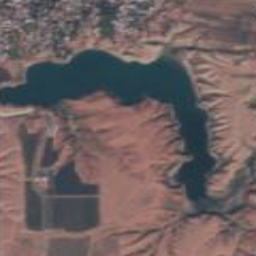

Original Mask   (256, 256, 1)


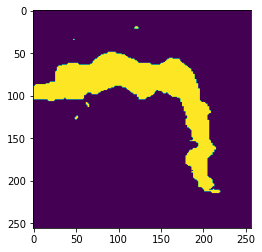

Predicted Mask   (256, 256, 1)


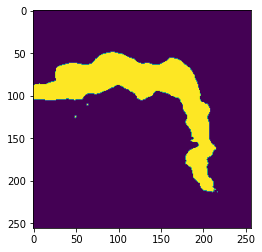

-------------------------------------------------------------


In [18]:
import random
i = random.randint(0,5) # < test_set_size

print( "Original Image" ,images[i].shape)
fig = px.imshow(images[i])
fig.update_layout(width=400, height=400)
fig.show()
print("Original Mask  " ,masks[i].shape)
plt.imshow(masks[i])
plt.show()
print("Predicted Mask  " ,preds[i].shape)
plt.imshow(preds[i])
plt.show()
print("-------------------------------------------------------------")

# IOU - Intersection Over Union Score

In [19]:
for ele in validation_dataset.take(validation_set_size):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 1, 0)
    Mean_IoU.update_state(y_true[0], prediction)
print("Mean IoU Score: ",Mean_IoU.result().numpy())

Mean IoU Score:  0.9731389


In [20]:
for ele in test_dataset.take(test_set_size):
    image, y_true = ele
    prediction = model.predict(image)[0]
    prediction = tf.where(prediction > 0.5, 1, 0)
    Mean_IoU.update_state(y_true[0], prediction)
print("Mean IoU Score: ",Mean_IoU.result().numpy())

Mean IoU Score:  0.9718857


References:

https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2

https://www.youtube.com/watch?v=QmCxqsbn5B0&t=71s
